In [5]:
import os, time
from tqdm import tnrange, tqdm_notebook, tqdm
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, autograd, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid
from torch.autograd import grad
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

In [6]:
now = int(time.time())

In [7]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [8]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 8)

%matplotlib inline

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
torch.cuda.is_available()

True

In [11]:
device_ids = [0]

In [12]:
BATCH_SIZE = 128
num_epochs = 100

z_dimension = 100

In [13]:
wh = 32
img_transform = transforms.Compose([
    transforms.Resize(wh),
    transforms.ToTensor(),
#     transforms.Normalize((.5, .5, .5), (.5, .5, .5))
#     transforms.Normalize((0.1307,), (0.3081,))
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST('~/data/mnist', transform=img_transform) #, download=True)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [14]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [15]:
def calc_gradient_penalty(netD, real_data, fake_data):
    alpha = torch.rand(1, 1, 1, 1)
    alpha = alpha.expand_as(real_data)
    alpha = alpha.to(device)
    
    interpolates = alpha * real_data.detach() + ((1 - alpha) * fake_data.detach())

    interpolates = interpolates.to(device)
    interpolates.requires_grad_(True)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradients = gradients.view(gradients.size(0), -1)                              
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * 10
    return gradient_penalty

In [16]:
class Discriminator(nn.Module):
    def __init__(self, d=128):
        super(Discriminator, self).__init__() # b d 32 32
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, d, 4, 2, 2),
            nn.LeakyReLU(.2, True),
            nn.BatchNorm2d(d),
        ) # d 16 16
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(d, d*2, 4, 2, 2),
            nn.LeakyReLU(.2, True),
            nn.BatchNorm2d(d*2),
        ) # d 16 16
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(d*2, d*4, 4, 2, 1),
            nn.LeakyReLU(.2, True),
            nn.BatchNorm2d(d*4),
        ) # d*4 4 4
        
        
        self.output = nn.Sequential(
            nn.Conv2d(d*4, 1, 4, 2, 1),
            nn.Sigmoid(),
        ) # 1 1 1
        
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
            
    def forward(self, x): # b 1 32 32

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        
        out = self.output(out)
        
        return out

In [17]:
class Generator(nn.Module):
    def __init__(self, z_dimension, d=128):
        super(Generator, self).__init__()
        
        self.upsample1 = nn.Sequential(
            nn.ConvTranspose2d(z_dimension, d*4, 4, 2, 1),
            nn.BatchNorm2d(d*4),
            nn.ReLU(True),
        ) # b d*8 2 2
        
        self.upsample2 = nn.Sequential(
            nn.ConvTranspose2d(d*4, d*2, 8, 2, 1),
            nn.BatchNorm2d(d*2),
            nn.ReLU(True),
        ) # b d*2 8 8
        
        self.upsample3 = nn.Sequential(
            nn.ConvTranspose2d(d*2, d, 4, 2, 1),
            nn.BatchNorm2d(d),
            nn.ReLU(True),
        ) # b d 16 16
        
        self.output = nn.Sequential(
            nn.ConvTranspose2d(d, 1, 4, 2, 1),
            nn.Tanh(),
        ) # b 1 32 32
        
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
            
    def forward(self, x): # b 100 1 1

        outs = self.upsample1(x)
        outs = self.upsample2(outs)
        outs = self.upsample3(outs)
        
        outs = self.output(outs)

        return outs

In [18]:
d = Discriminator().to(device)
g = Generator(z_dimension).to(device)

d.weight_init(.0, 0.02)
g.weight_init(.0, 0.02)

d = nn.DataParallel(d, device_ids=device_ids).to(device)
g = nn.DataParallel(g, device_ids=device_ids).to(device)

criterion = nn.BCELoss()

d_optimezer = optim.Adam(d.parameters(), lr=2e-4, betas=(0, 0.9))
g_optimezer = optim.Adam(g.parameters(), lr=2e-4, betas=(0, 0.9))

one = torch.FloatTensor([1])
mone = one * -1
one = one.to(device)
mone = mone.to(device)

In [15]:
writer = SummaryWriter(os.path.join('./log/cnn_wgan_gp', str(now)))

In [16]:
img_path = os.path.join("save_images/cnn_wgan_img", str(now))
if not os.path.exists(img_path): os.makedirs(img_path)

In [17]:
total_count = len(dataloader)
for epoch in tqdm_notebook(range(num_epochs)):
    _step = epoch * total_count
    
    d_loss_total = .0
    g_loss_total = .0
    for i, (img, _) in enumerate(dataloader):

        real_img = img.cuda()
        z = torch.randn(img.size(0), z_dimension, 1, 1).cuda()
        
        ########## G ##########
        fake_img = g(z)
        fake_out = d(fake_img)
        g_loss = -fake_out.mean()
        
        g_optimezer.zero_grad()
        g_loss.backward()
        g_optimezer.step()
        #######################
        
        ########## D ##########
        real_out = d(real_img)
        d_loss_real = real_out.mean()
        real_scores = real_out
        
        fake_out = d(fake_img.detach())
        d_loss_fake = fake_out.mean()
        fake_scores = fake_out
        
        gradient_penalty = calc_gradient_penalty(d, real_img, fake_img)
        
        d_loss = d_loss_fake - d_loss_real + gradient_penalty
        d_optimezer.zero_grad()
        d_loss.backward()
        d_optimezer.step()
        #######################
        w_dist = d_loss_fake - d_loss_real
        
        
        d_loss_total += d_loss.item() * img.size(0)
        g_loss_total += g_loss.item() * img.size(0)
        
        step = _step + i + 1
        
        if (i + 1) % 100 == 0:
            writer.add_scalar('Discriminator Real Loss', d_loss_real.item(), step)
            writer.add_scalar('Discriminator Fake Loss', d_loss_fake.item(), step)
            writer.add_scalar('Discriminator Loss', d_loss.item(), step)
            writer.add_scalar('Generator Loss', g_loss.item(), step)
            writer.add_scalar('Wasserstein Distance', w_dist.item(), step)
        
        
        if (i + 1) % 300 == 0:
            tqdm.write('Epoch [{}/{}], Step: {:6d}, d_loss: {:.6f}, g_loss: {:.6f}, real_scores: {:.6f}' \
', fake_scores: {:.6f}, w: {:.6f}'.format(epoch+1, num_epochs, (i+1) * BATCH_SIZE, d_loss, g_loss, real_scores.mean(), fake_scores.mean(), w_dist))
    
    
    setp = (epoch + 1) * total_count
    _d_loss_total = d_loss_total / (total_count * (epoch + 1))
    _g_loss_total = g_loss_total / (total_count * (epoch + 1))
    
    writer.add_scalar('Discriminator Total Loss', _d_loss_total, step)
    writer.add_scalar('Generator Total Loss', _g_loss_total, step)
    
    tqdm.write("Finish Epoch [{}/{}], D Loss: {:.6f}, G Loss: {:.6f}".format(epoch+1, 
                                                                             num_epochs, 
                                                                             _d_loss_total,
                                                                             _g_loss_total, ))
    
    writer.add_image('Generator Image', make_grid(fake_img.view(-1, 1, wh, wh).cpu().data, normalize=True, scale_each=True), step)
    
    if epoch == 0:
        real_images = real_img.view(-1, 1, wh, wh).cpu().data
        save_image(real_images, os.path.join(img_path, 'real_images.png'))
    
    
    fake_images = fake_img.view(-1, 1, wh, wh).cpu().data
    save_image(fake_images, os.path.join(img_path, 'fake_images-{}.png'.format(epoch+1)))

Epoch [1/100], Step:  38400, d_loss: 0.611789, g_loss: -0.932485, real_scores: 0.598294, fake_scores: 0.932485, w: 0.334192
Finish Epoch [1/100], D Loss: 172.252611, G Loss: -77.139045
Epoch [2/100], Step:  38400, d_loss: 0.002435, g_loss: -0.397276, real_scores: 0.798641, fake_scores: 0.397276, w: -0.401365
Finish Epoch [2/100], D Loss: 59.980317, G Loss: -32.646253
Epoch [3/100], Step:  38400, d_loss: 0.228842, g_loss: -0.481510, real_scores: 0.735850, fake_scores: 0.481510, w: -0.254340
Finish Epoch [3/100], D Loss: 24.215710, G Loss: -22.458465
Epoch [4/100], Step:  38400, d_loss: -0.065842, g_loss: -0.466281, real_scores: 0.658166, fake_scores: 0.466281, w: -0.191885
Finish Epoch [4/100], D Loss: 2.668072, G Loss: -15.703456
Epoch [5/100], Step:  38400, d_loss: 0.042489, g_loss: -0.638041, real_scores: 0.792153, fake_scores: 0.638041, w: -0.154112
Finish Epoch [5/100], D Loss: -2.515319, G Loss: -10.955654
Epoch [6/100], Step:  38400, d_loss: -0.390275, g_loss: -0.336004, real_sco

KeyboardInterrupt: 

In [18]:
writer.close()

In [19]:
torch.save(d.state_dict(), './ser/wgan_gp_discriminator.pt')
torch.save(g.state_dict(), './ser/wgan_gp_generator.pt')

In [19]:
d.load_state_dict(torch.load('./ser/wgan_gp_discriminator.pt'))
g.load_state_dict(torch.load('./ser/wgan_gp_generator.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

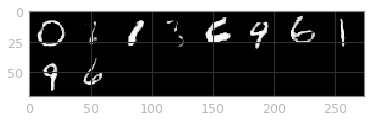

In [21]:
z = torch.randn(10, z_dimension, 1, 1).to(device)
images = g(z)
# save_image(images, 'xx.png')
plt.imshow(Image.fromarray(make_grid(images).mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()))
plt.show()